In [0]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [0]:
env = gym.make('CartPole-v0')
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Policy(nn.Module):
  
  def __init__(self, s_size=4, h_size=16, a_size=2):
    super(Policy, self).__init__()
    self.fc1 = nn.Linear(s_size, h_size)
    self.fc2 = nn.Linear(h_size, a_size)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return F.softmax(x, dim=1)

  def act(self, state):
    state = torch.from_numpy(state).unsqueeze(0).float().to(device)
    probs = self.forward(state).cpu()
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)

policy = Policy().to(device)

In [0]:
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
  scores = []
  scores_deque = deque(maxlen=100)

  for i_episode in range(1, n_episodes+1):
    saved_log_probs = []
    rewards = []
    state = env.reset()

    for i in range(max_t):
      action, log_prob = policy.act(state)
      saved_log_probs.append(log_prob)
      state, reward, done, _ = env.step(action)
      rewards.append(reward)
      if done:
        break
    
    scores.append(sum(rewards))
    scores_deque.append(sum(rewards))

    discounts = [gamma**1 for i in range(len(rewards) + 1)]
    R = sum([a*b for a, b in zip(discounts, rewards)])

    policy_loss = []
    for log_prob in saved_log_probs:
      policy_loss.append(-log_prob*R)
    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    torch.save(policy.state_dict(), 'checkpoint.pth')

    if i_episode % print_every == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    if np.mean(scores_deque)>=195.0:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        break
  return scores

Episode 100	Average Score: 20.88
Episode 200	Average Score: 47.11
Episode 300	Average Score: 58.28
Episode 400	Average Score: 133.18
Episode 500	Average Score: 109.26
Episode 600	Average Score: 155.30
Episode 700	Average Score: 183.86
Environment solved in 618 episodes!	Average Score: 196.32


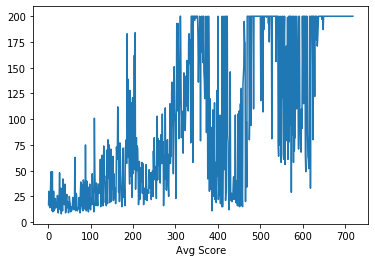

In [0]:
scores = reinforce()

plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel('Episodes')
plt.xlabel('Avg Score')
plt.show()

In [0]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(10000):
    action, _ = policy.act(state)
    env.render()
    time.sleep(0.01)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()